### **Machine Learning Star Classification**
Classification of stars based on their spectral characteristics

**Authors:**
- *Stefano Quaggio 866504*
- *Stefano Andreotti 851596*
- *Alberto Varisco 866109*

**Classification models used:**
- <u>Neural Networks</u>
- <u>SVM</u>
- <u>K-Means Algorithm</u>

## <u>Initial Analysis</u>

In [20]:
# All libraries imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras

from sklearn.preprocessing import LabelEncoder, label_binarize,StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm,calibration

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping 
from keras.optimizers import Adam

from scipy import stats

#Diamo accesso al nostro google drive che conterrà il dataset che utilizzeremo in questo laboratorio
# from google.colab import drive

# drive.mount('/content/drive/')

In [21]:
# accuracy_stratified: list of classification_report_results as dict
# returns dict like scores
def extractScoresFromClassificationReport(accuracy_stratified : list):
  scores = {
  'precision': [],
  'recall': [],
  'f1-score': [],
  }
  for index, val in enumerate(accuracy_stratified):
    scores['precision'].append(val['macro avg']['precision'])
    scores['recall'].append(val['macro avg']['recall'])
    scores['f1-score'].append(val['macro avg']['f1-score'])
  return scores

# Imput list of data
# Returns tuple (confidence_interval, mean_value)
def calcConfidenceInterval(data : list):
  mean_value = np.mean(data)
  return (stats.t.interval(0.95, len(data)-1, loc=mean_value, scale=stats.sem(data)), mean_value)


# Parameter accuracy_stratified: list of classification_report returned as dict
# Run confidence_intervals on metrics output plot, legend print legend
def metricGraph(accuracy_stratified : list, legend : bool = True, title : string = "Metrics with Confidence Interval (0.95)") -> None:
  scores = extractScoresFromClassificationReport(accuracy_stratified)
  
  for index, key in enumerate(scores):
    val = scores[key]
    confidence_interval, mean_value = calcConfidenceInterval(val)
    plt.errorbar(index, mean_value, yerr=(confidence_interval[1] - confidence_interval[0])/2, fmt='o', label=key)
  # ticks on x axis with labels
  plt.xticks(range(0, len(scores.keys())), scores.keys())

  # Add labels and title
  plt.xlabel('Metrics')
  plt.ylabel('Values')
  plt.title(title)

  # Show the plot
  if legend:
    plt.legend()
  plt.show()

In [22]:
full_df = pd.read_csv('../dataset/star_classification.csv')

full_df.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [23]:
full_df.info()
# Check number of missing values in columns
full_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

array([[<Axes: title={'center': 'obj_ID'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'delta'}>, <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'i'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'run_ID'}>,
        <Axes: title={'center': 'rerun_ID'}>,
        <Axes: title={'center': 'cam_col'}>,
        <Axes: title={'center': 'field_ID'}>],
       [<Axes: title={'center': 'spec_obj_ID'}>,
        <Axes: title={'center': 'redshift'}>,
        <Axes: title={'center': 'plate'}>,
        <Axes: title={'center': 'MJD'}>],
       [<Axes: title={'center': 'fiber_ID'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

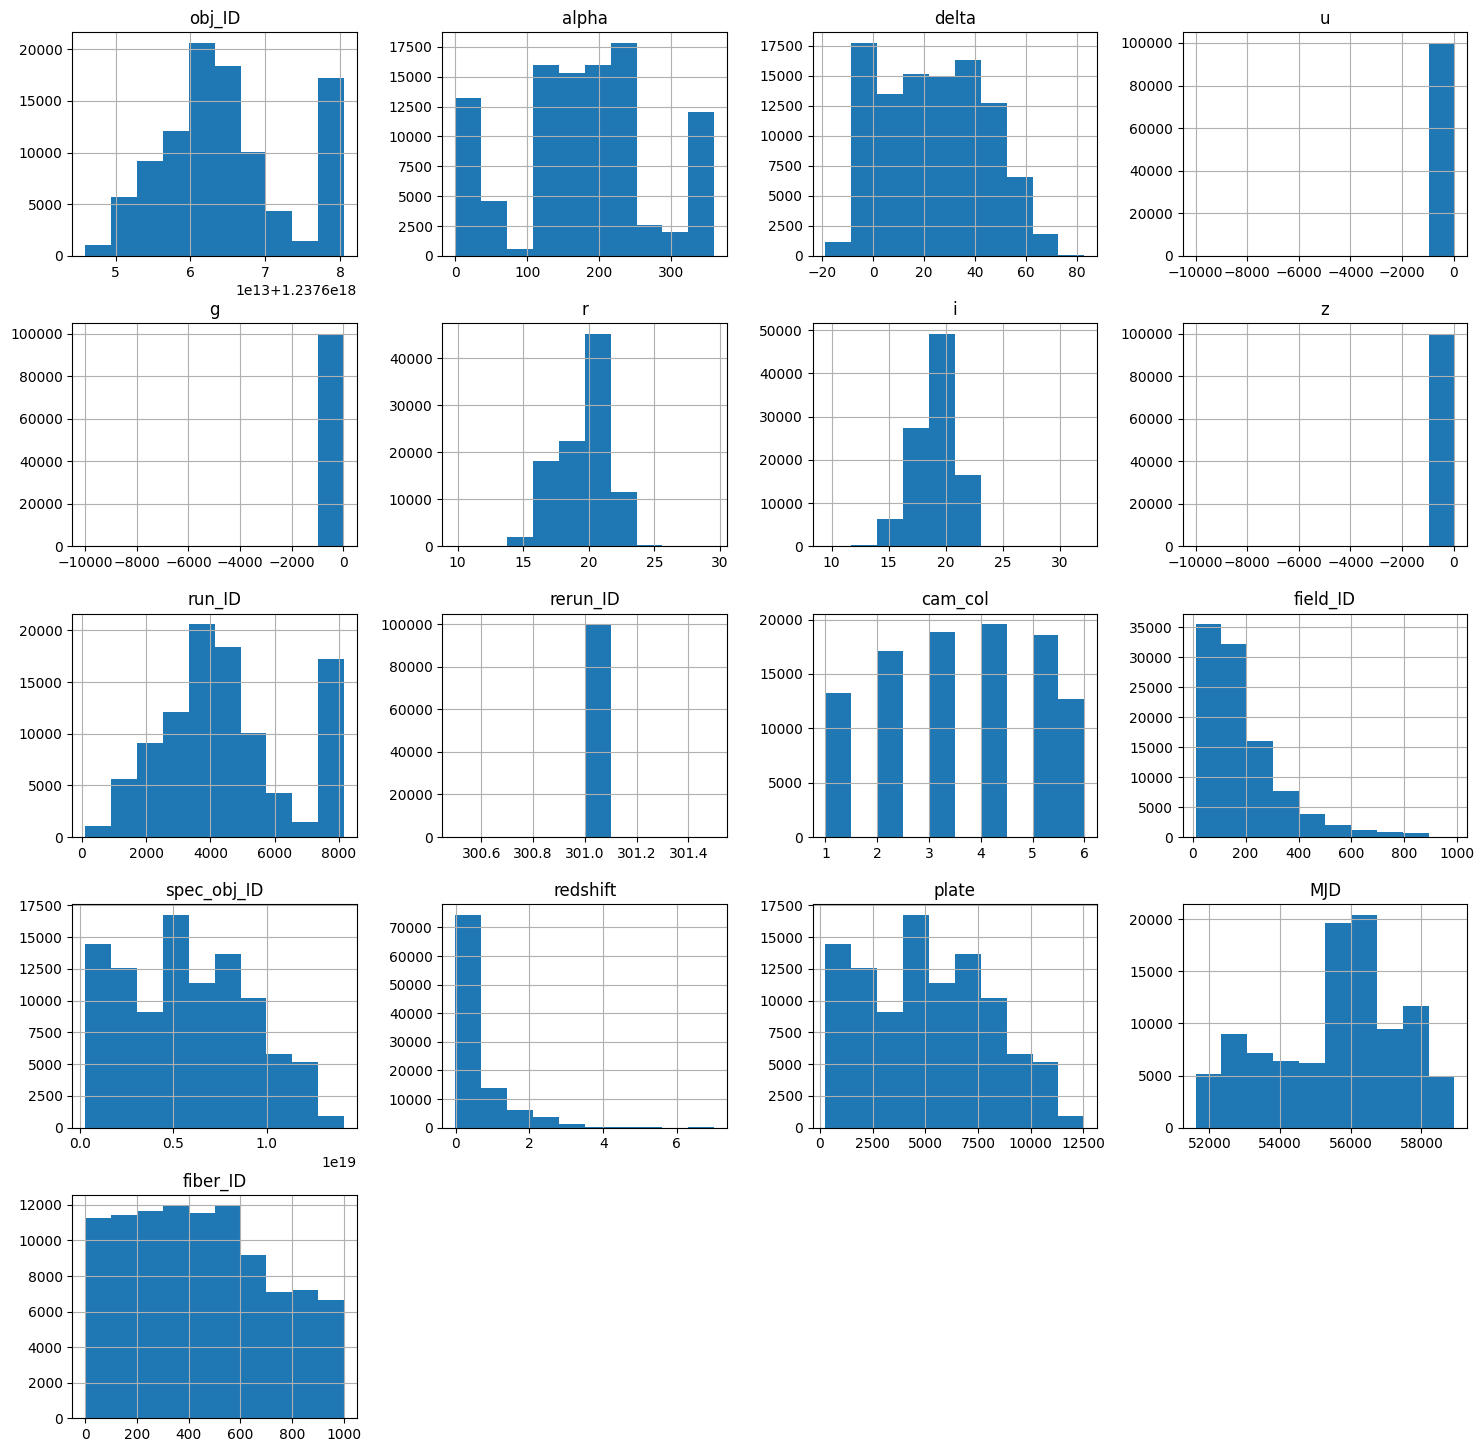

In [24]:
full_df.hist(figsize=(18,18))

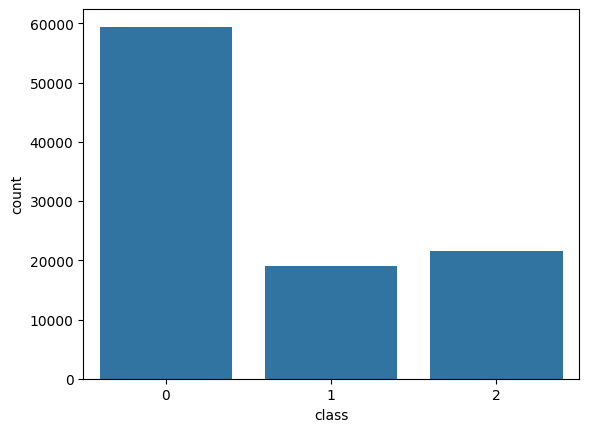

In [25]:
# Initialize LabelEncoder object
label_encoder = LabelEncoder()

# Apply LabelEncoder on 'class' column (target) -> 0 = Galaxy, 1 = Quasar, 2 = Star
full_df['class'] = label_encoder.fit_transform(full_df['class'])
# create dict with { label: value } (funziona solo quando viene eseguito dall'inizio se no diventa { value: value })
#label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# per non dover rieseguire tutto il codice dall'inizio
label_mapping = { 'Galaxy': 0, 'Quasar': 1, 'Star': 2 }

#Check distribution of target variable
sns.countplot(x = full_df['class'])
plt.show()

<Axes: >

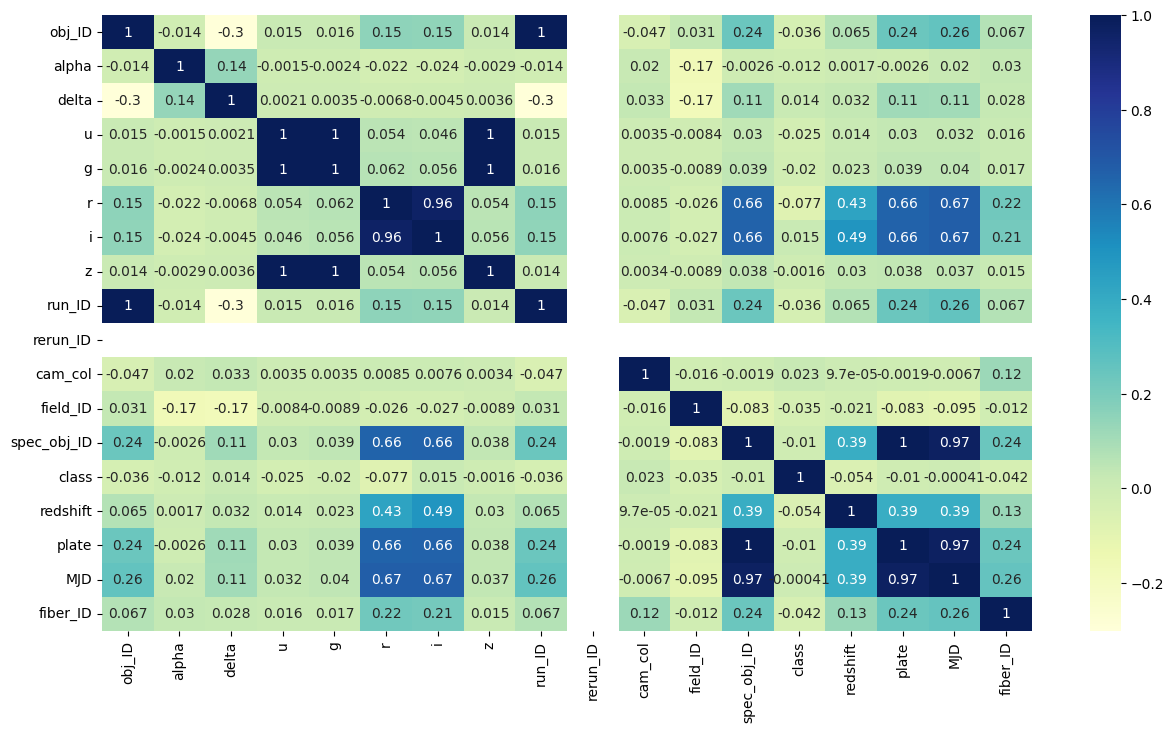

In [26]:
# Check correlation between features
plt.figure(figsize=(15,8))
sns.heatmap(full_df.corr(), annot=True, cmap='YlGnBu')

In [27]:
# Remove 'rerun_ID' column as it has only one value and is not useful for classification
if 'return_ID' in full_df:
  full_df.drop(['rerun_ID'], axis=1, inplace=True)

# Split dataset into train and test sets
x = full_df.drop(['class'], axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()


## Rete neurale

In [28]:
# Feature scaling (standardization)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-0.10916851, -1.66771202, -1.18136427, ..., -0.95094121,
        -1.02748604, -0.10879273],
       [ 0.09744164,  0.32370141,  0.01744206, ..., -1.02167337,
        -0.99214013, -0.72545665],
       [-0.63704129,  0.64727649,  1.06578962, ...,  1.1398877 ,
         1.27275931, -1.05214171],
       ...,
       [ 0.29636369, -0.40170548, -0.13958489, ...,  1.49727121,
         1.23078604,  1.13921759],
       [-0.82121912, -0.44842117,  1.01680361, ...,  0.4264744 ,
         0.42390526, -1.16226026],
       [-1.39370554,  1.54157522, -1.66760705, ..., -1.52085962,
        -1.88628112, -0.57129067]])

In [29]:
# Convert target variable to categorical, as it is a multi-class classification problem
y_train_neural = keras.utils.to_categorical(y_train)
y_test_neural = keras.utils.to_categorical(y_test)
print(X_test.shape, y_test_neural.shape)

print(y_train_neural)

(20000, 17) (20000, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


c:\Users\Varo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7718 - loss: 0.5605 - val_accuracy: 0.9342 - val_loss: 0.1983
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9396 - loss: 0.1918 - val_accuracy: 0.9409 - val_loss: 0.1727
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9531 - loss: 0.1538 - val_accuracy: 0.9564 - val_loss: 0.1421
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9589 - loss: 0.1378 - val_accuracy: 0.9603 - val_loss: 0.3592
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9615 - loss: 0.1296 - val_accuracy: 0.9628 - val_loss: 0.3796
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9625 - loss: 0.1240 - val_accuracy: 0.9625 - val_loss: 0.4236
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9633 - loss: 0.1230 - val_accuracy: 0.9570 - val_loss: 0.4395
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9637 - loss: 0.1213 - val_accuracy: 0.

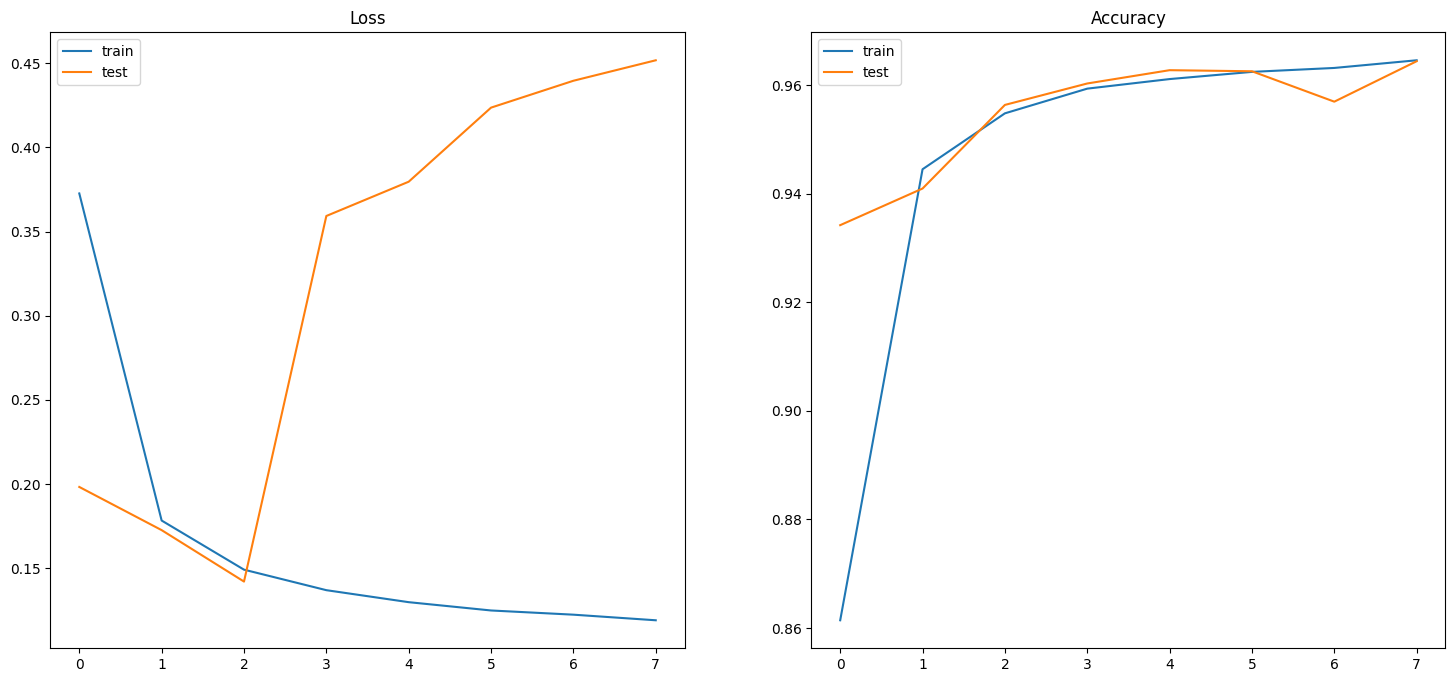

In [30]:
input_features = X_train.shape[1]

def define_NN_model():
    nn_model=Sequential()
    nn_model.add(Dense(32, input_dim=input_features, activation='relu'))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(3, activation='softmax'))
    nn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return nn_model

neural_model=define_NN_model()

# Early stopping 
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = neural_model.fit(X_train, y_train_neural, epochs=50, batch_size=100, verbose=1, validation_data=(X_test, y_test_neural), callbacks=[callback])

# Evaluate the model on the test set
_, train_acc = neural_model.evaluate(X_train, y_train_neural, verbose=0)
_, test_acc = neural_model.evaluate(X_test, y_test_neural, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss during training
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [31]:
# predict probabilities for test set
yhat_probs = neural_model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes=np.argmax(yhat_probs,axis=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

y_test_unidimension = [0 if val[0] else 1 if val[1] else 2 for val in y_test_neural]
    
print(classification_report(y_test_unidimension, yhat_classes, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

      Galaxy       0.97      0.96      0.96     11970
      Quasar       0.95      0.91      0.93      3837
        Star       0.93      0.99      0.96      4193

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000



10-Fold

In [32]:
n_fold = 10
epochs = 30
folds = KFold(n_splits=n_fold, shuffle=True)

nn_k_fold_metrics = []

scaler = StandardScaler()

fold_neural_model=define_NN_model()
fold_neural_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


for n_fold, (train_idx, valid_idx) in enumerate(folds.split(x, y)):
    # split data with corss validation indexes
    X_t, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
    X_t = scaler.fit_transform(X_t)
    X_valid = scaler.fit_transform(X_valid)
    y_t, y_valid = y[train_idx], y[valid_idx]
    y_valid = keras.utils.to_categorical(y_valid)
    y_t = keras.utils.to_categorical(y_t)


    # train model on fold
    history = fold_neural_model.fit(X_t, y_t, epochs=epochs, batch_size=100, verbose=1, validation_data=(X_valid, y_valid), callbacks=[callback])

    # predict probabilities for test set
    y_pred_fold_neural_model = fold_neural_model.predict(X_valid, verbose=0)
    # predict crisp classes for test set
    yhat_classes=np.argmax(y_pred_fold_neural_model, axis=1)
    # reduce to 1d array
    y_pred_fold_neural_model = y_pred_fold_neural_model[:, 0]

    y_test_unidimension = [0 if val[0] else 1 if val[1] else 2 for val in y_valid]
        
    nn_k_fold_metrics.append(classification_report(y_test_unidimension, yhat_classes, target_names=label_mapping.keys(), output_dict=True))

Epoch 1/30


c:\Users\Varo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7451 - loss: 0.6047 - val_accuracy: 0.6754 - val_loss: 1.2014
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9385 - loss: 0.2033 - val_accuracy: 0.6764 - val_loss: 1.1427
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9504 - loss: 0.1726 - val_accuracy: 0.7273 - val_loss: 1.0455
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9548 - loss: 0.1489 - val_accuracy: 0.7340 - val_loss: 1.1114
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9603 - loss: 0.1352 - val_accuracy: 0.7332 - val_loss: 1.1554
Epoch 1/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9390 - loss: 0.1933 - val_accuracy: 0.7072 - val_loss: 0.9940
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9508 - loss: 0.1653 - val_accuracy: 0.7579 - val_loss: 1.0508
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9553 - loss: 0.1458 - val_accuracy: 0.7370 - val_

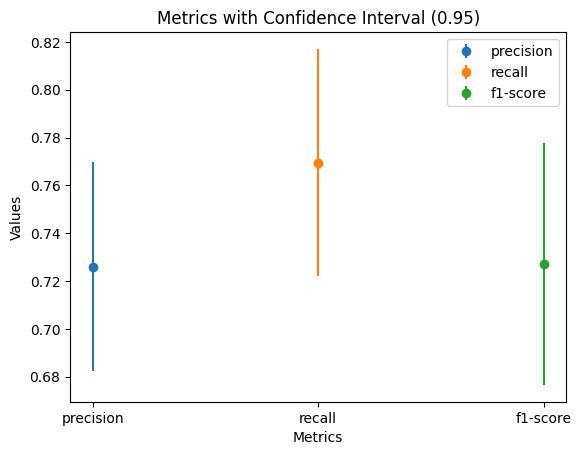

In [33]:
metricGraph(nn_k_fold_metrics)

## SVM

In [34]:
# Split dataset into train and test sets
x = full_df.drop(['class'], axis=1)
y = full_df['class']
# Feature scaling (standardization)
# NEEDED for LinearSVC
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

# Print class distribution over training set
print(f"#0: {np.sum(y_train == 0)}")
print(f"#1: {np.sum(y_train == 1)}")
print(f"#2: {np.sum(y_train == 2)}")

#0: 47609
#1: 15156
#2: 17235


In [35]:
# Crea il classificatore SVM
svm_model =  OneVsRestClassifier(svm.LinearSVC(dual="auto", tol=1e-5, C=1))
# per avere probability_distribution sv = CalibratedClassifierCV(sv) (curva roc)
svm_model = calibration.CalibratedClassifierCV(svm_model) 

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# calcolo dell'accuratezza
# label_mapping dict: Galaxy = 0, Quasar = 1, Star = 2
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuratezza: {accuracy}\n\n")
print(classification_report(y_test, y_pred_svm, target_names=label_mapping.keys()))

Accuratezza: 0.9493


              precision    recall  f1-score   support

      Galaxy       0.95      0.97      0.96     11836
      Quasar       0.93      0.90      0.92      3805
        Star       0.96      0.95      0.96      4359

    accuracy                           0.95     20000
   macro avg       0.95      0.94      0.94     20000
weighted avg       0.95      0.95      0.95     20000



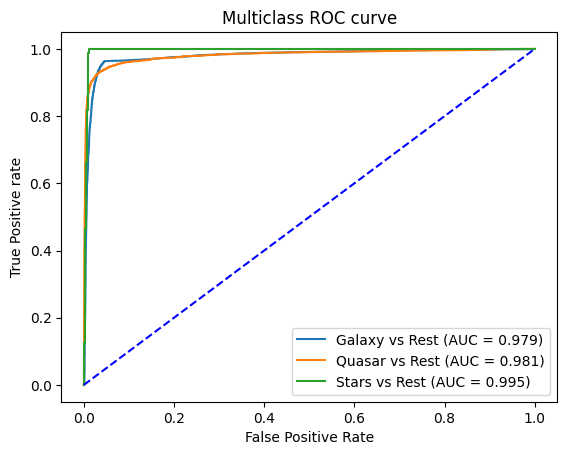

In [36]:
#binarize the y_values
y_pred_prob_svm = svm_model.predict_proba(X_test)
classes=np.unique(y_test)
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_pred_prob_svm[:,i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:,i], y_pred_prob_svm[:,i])
    
    # plotting    
plt.plot(fpr[0], tpr[0],label='Galaxy vs Rest (AUC = %0.3f)'%(roc_auc[0]))
plt.plot(fpr[1], tpr[1], label='Quasar vs Rest (AUC = %0.3f)'%(roc_auc[1]))
plt.plot(fpr[2], tpr[2], label='Stars vs Rest (AUC = %0.3f)'%(roc_auc[2]))

plt.plot([0,1],[0,1],'b--')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()


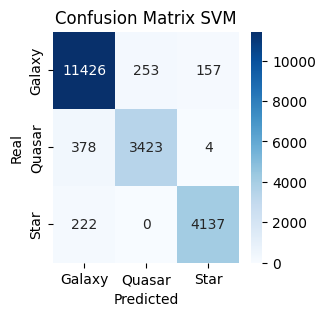

In [37]:
conf_matrix_dt = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues", xticklabels=list(("Galaxy", "Quasar", "Star")), yticklabels=list(("Galaxy", "Quasar", "Star")))
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix SVM')
plt.show()

K-fold

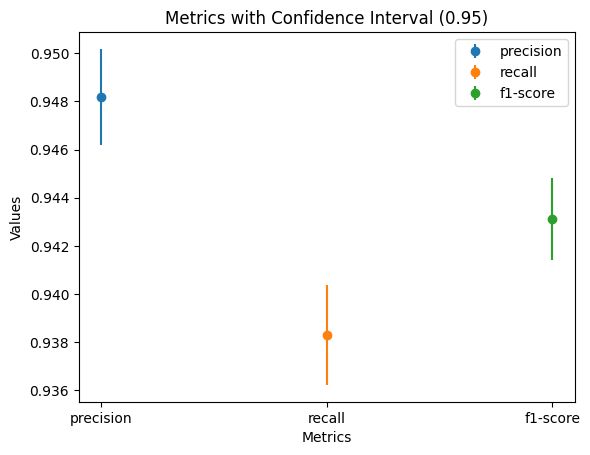

In [38]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True)

svm_k_fold_metrics = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(x_scaled, y)):
  # split data with corss validation indexes
  X_train, X_valid = x_scaled.iloc[train_idx], x_scaled.iloc[valid_idx]
  y_train, y_valid = y[train_idx], y[valid_idx]

  # train model on fold
  svm_model.fit(X_train, y_train)
  y_pred_svm_fold = svm_model.predict(X_valid)
  # save scores of fold
  svm_k_fold_metrics.append(classification_report(y_valid, y_pred_svm_fold, target_names=label_mapping.keys(), output_dict=True))

metricGraph(svm_k_fold_metrics)

## Decision Tree


In [39]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state = 30)
decision_tree_model.fit(X_train, y_train)
y_pred_dt = decision_tree_model.predict(X_test)

dtree_score = recall_score(y_test, y_pred_dt, average='weighted')
print(dtree_score)

0.99635


In [40]:
# Stampa albero
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(decision_tree_model, filled=True, ax=ax)
plt.plot()
# Salva l'albero
# plt.savefig("quattr.svg", format="svg")

[]

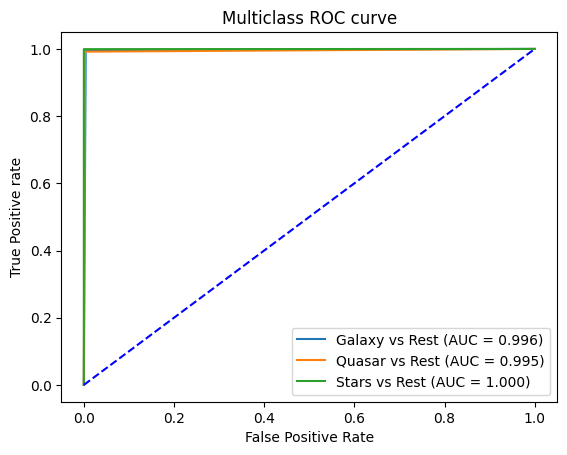

In [41]:
y_pred_prob_dt = decision_tree_model.predict_proba(X_test)
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc_dt = dict()

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_pred_prob_dt[:,i])
    roc_auc_dt[i] = roc_auc_score(y_test_binarized[:,i], y_pred_prob_dt[:,i])
    
    # plotting    
plt.plot(fpr[0], tpr[0],label='Galaxy vs Rest (AUC = %0.3f)'%(roc_auc_dt[0]))
plt.plot(fpr[1], tpr[1], label='Quasar vs Rest (AUC = %0.3f)'%(roc_auc_dt[1]))
plt.plot(fpr[2], tpr[2], label='Stars vs Rest (AUC = %0.3f)'%(roc_auc_dt[2]))

plt.plot([0,1],[0,1],'b--')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

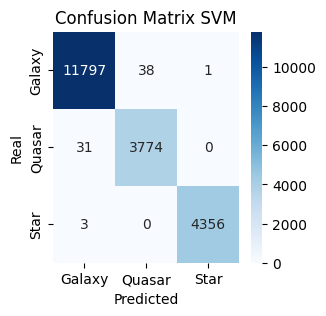

In [42]:
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues", xticklabels=list(("Galaxy", "Quasar", "Star")), yticklabels=list(("Galaxy", "Quasar", "Star")))
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix SVM')
plt.show()

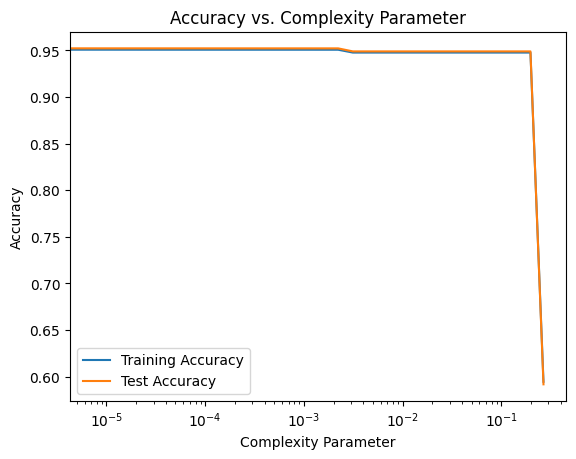

In [43]:
path = decision_tree_model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
# Valori di complessità = [0.001, 0.01, 0.1, 1, 10, 100]
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [44]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.26755297198928424


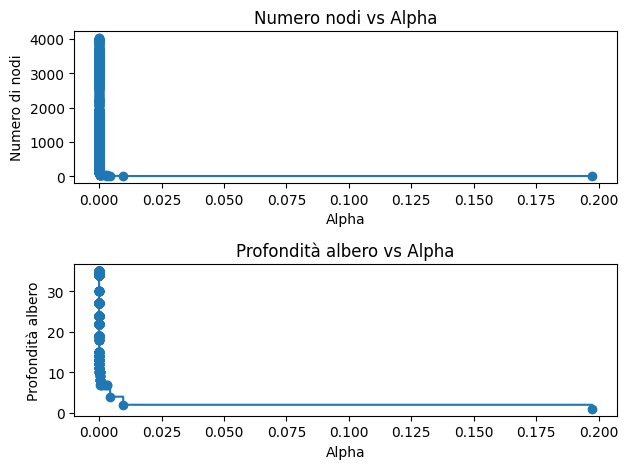

In [45]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Numero di nodi")
ax[0].set_title("Numero nodi vs Alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Profondità albero")
ax[1].set_title("Profondità albero vs Alpha")
fig.tight_layout()

K-fold

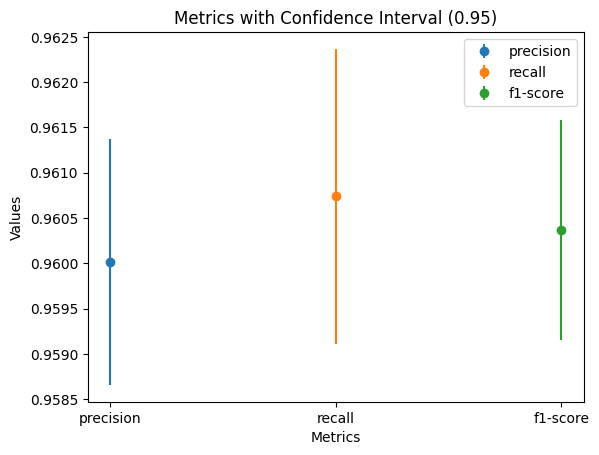

In [53]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True)

tree_k_fold_metrics = []
decision_tree_model = DecisionTreeClassifier()


for n_fold, (train_idx, valid_idx) in enumerate(folds.split(x, y)):
  # split data with corss validation indexes
  X_train, X_valid = x_scaled.iloc[train_idx], x_scaled.iloc[valid_idx]
  y_train, y_valid = y[train_idx], y[valid_idx]

  # train model on fold
  decision_tree_model.fit(X_train, y_train)
  y_pred_dt_fold = decision_tree_model.predict(X_valid)
  # save scores of fold
  tree_k_fold_metrics.append(classification_report(y_valid, y_pred_dt_fold, target_names=label_mapping.keys(), output_dict=True))

metricGraph(tree_k_fold_metrics)

# Compare

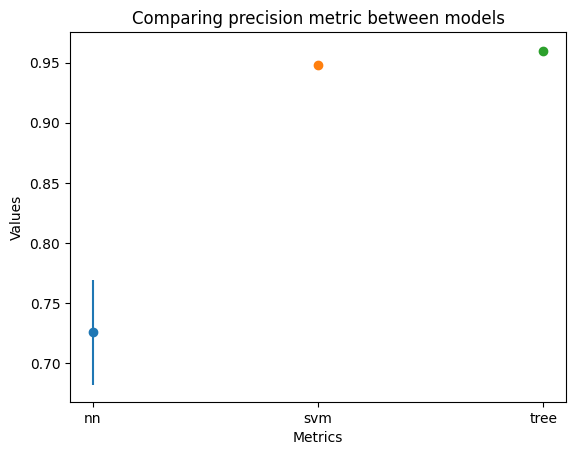

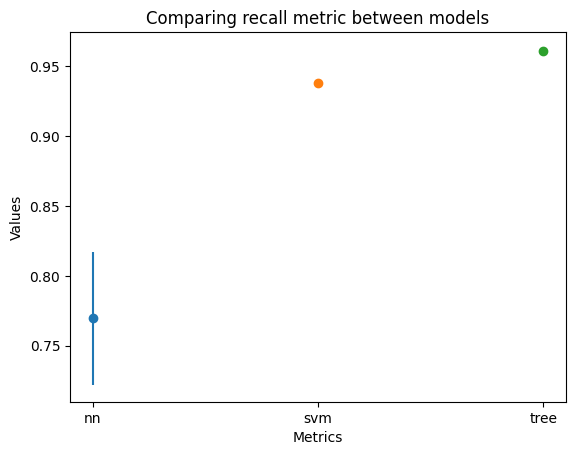

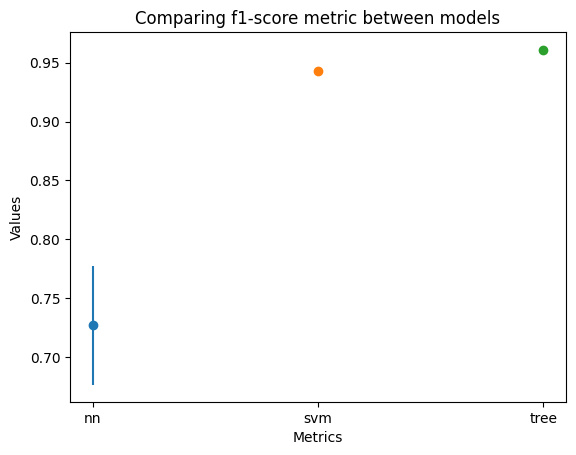

In [55]:
nn_scores = extractScoresFromClassificationReport(nn_k_fold_metrics)
svm_scores = extractScoresFromClassificationReport(svm_k_fold_metrics)
tree_score = extractScoresFromClassificationReport(tree_k_fold_metrics)

for key in nn_scores:
  nn_confint, nn_mean_val = calcConfidenceInterval(nn_scores[key])
  plt.errorbar(0, nn_mean_val, yerr=(nn_confint[1] - nn_confint[0])/2, fmt='o', label='nn')

  svm_confint, svm_mean_val = calcConfidenceInterval(svm_scores[key])
  plt.errorbar(1, svm_mean_val, yerr=(svm_confint[1] - svm_confint[0])/2, fmt='o', label='svm')

  tree_confint, tree_mean_val = calcConfidenceInterval(tree_score[key])
  plt.errorbar(2, tree_mean_val, yerr=(tree_confint[1] - tree_confint[0])/2, fmt='o', label='tree')

  # ticks on x axis with labels
  plt.xticks(range(0, 3), ['nn', 'svm', 'tree'])

  # Add labels and title
  plt.xlabel('Metrics')
  plt.ylabel('Values')
  plt.title(f"Comparing {key} metric between models")
  # Show the plot
  plt.show()
